# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

In this notebook I combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. In the data set informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, we can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase is provided. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

It should be noted that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

This makes data cleaning especially important and tricky.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

The schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot  as plt

% matplotlib inline

In [2]:
# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.shape

(10, 6)

Only 10 types of offers

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


bogo's have the same reward as difficulty as they are buy one get one free

In [6]:
profile.shape

(17000, 5)

In [7]:
# Correct Column Formating
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

# Change id column to prevent confusion
profile = profile.rename(columns={'id':'customer_id'})

In [8]:
profile.head()

,age,became_member_on,gender,customer_id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null datetime64[ns]
gender              14825 non-null object
customer_id         17000 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.1+ KB


In [10]:
#Convert to a categorical data type
profile.gender = profile.gender.astype('category')

In [11]:
profile[profile['income'].isnull()].count()

age                 2175
became_member_on    2175
gender                 0
customer_id         2175
income                 0
dtype: int64

In [12]:
profile.isna().sum(axis=0)

age                    0
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

May decide to remove these rows

In [13]:
transcript.shape

(306534, 4)

In [14]:
# Rename column to prevent confusion
transcript = transcript.rename(columns={'person':'customer_id'})

In [15]:
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


'person' is the 'id' values of the other columns, hence renamed to 'customer_id' to keep in line

In [16]:
transcript.isna().sum(axis=0)

event          0
customer_id    0
time           0
value          0
dtype: int64

In [17]:
transcript[transcript["customer_id"]=="78afa995795e4d85b5d9ceeca43f5fef"]

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


- Transactions are not offer related rows. These are other deals.
- Let's investigate the offers. Won't need the 'transaction' event - will remove these

## Data Wrangling

Clean up portfolio df

In [18]:
#Creating a new df
df_portfolio = portfolio.copy()

#Rename ID column to prevent confusion
df_portfolio = df_portfolio.rename(columns={'id':'offer_id'})

#pd.get_dummies converts the stacked variables into boolean values
channel_stack = pd.get_dummies(df_portfolio.channels.apply(pd.Series).stack()).sum(level=0)
#More info about:
    #pd.get_dummies can be found here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
    #stacking can be found here: https://www.geeksforgeeks.org/reshape-a-pandas-dataframe-using-stackunstack-and-melt-method/
df_portfolio = pd.concat([df_portfolio, channel_stack], axis=1)

#Drop old column
df_portfolio.drop(columns='channels', inplace=True)

In [19]:
df_portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


Clean up transcript df

In [20]:
# Create a copy of the transcript df before making further changes
df_transcript = transcript.copy()

In [21]:
# Create a boolean mask based on the condition to drop transaction rows
condition = df_transcript['event'] != 'transaction'
# Use the boolean mask to filter the DataFrame
filtered_df = df_transcript[condition]

In [22]:
df_transcript = filtered_df

# Repeat get_dummies method
event_dummies = pd.get_dummies(df_transcript['event'])
df_transcript = pd.concat([df_transcript, event_dummies], axis=1 )

In [23]:
df_transcript.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

In [24]:
# Rename ID column for consistency
df_transcript = df_transcript.rename(columns={'value':'offer_id'})

# Drop old column
df_transcript.drop(columns='event', inplace=True)

In [25]:
df_transcript.head()

,customer_id,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0


In [26]:
def clean_offer_column(df):
    '''
    Function to cleaning the transcript dataframe, return dataframe containing the correct offer id's
    
    INPUT:
    df - dataframe to be cleaned
    OUTPUT:
    offer - cleaned dataframe offer column
    '''
    # Extract rows related to offer action (e.g. offer received, offer viewed, offer completed)
    offer = df[df['offer_id'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # Extract offer_id from value column
    offer['offer_id'] = offer['offer_id'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

In [27]:
df_transcript_cleaned = clean_offer_column(df_transcript)

In [28]:
df_transcript_cleaned.head()

,customer_id,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


Can merge columns now as offer_id column cleaned and usuable

## Initial EDA

It would be beneficial to do some EDA on the customer (profile) data before merging.

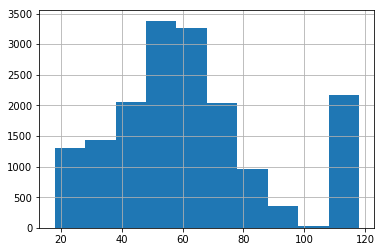

In [29]:
profile.age.hist();

Will remove everyone equal to 118 as these were encoded as missing values.

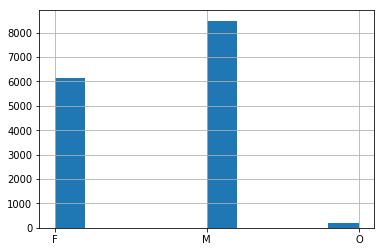

In [30]:
profile.gender.hist();

More males than females

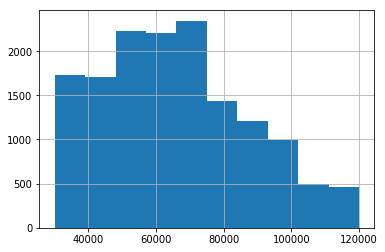

In [31]:
profile.income.hist();

Few top earners. No outliers can be seen.

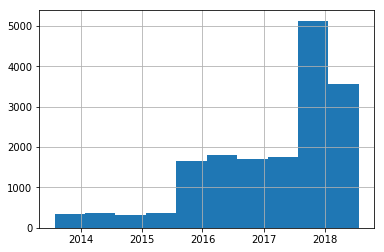

In [32]:
profile.became_member_on.hist();

Most members joined after Q2 in 2017

## Merging DFs

First merging together the cleaned transcript data and customer profile data

In [33]:
df_temp = pd.merge(df_transcript_cleaned, profile, on='customer_id')

In [34]:
df_temp.head()

,customer_id,time,offer_id,offer completed,offer received,offer viewed,age,became_member_on,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,75,2017-05-09,F,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,75,2017-05-09,F,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,75,2017-05-09,F,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,1,0,75,2017-05-09,F,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,0,0,1,75,2017-05-09,F,100000.0


Then merging together with the portfolio of offers dataframe.

In [35]:
df_full = pd.merge(df_temp, df_portfolio, on='offer_id')

In [36]:
df_full.head()

,customer_id,time,offer_id,offer completed,offer received,offer viewed,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,75,2017-05-09,F,100000.0,5,7,bogo,5,1,1,0,1
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,75,2017-05-09,F,100000.0,5,7,bogo,5,1,1,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,75,2017-05-09,F,100000.0,5,7,bogo,5,1,1,0,1
3,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,68,2018-04-26,M,70000.0,5,7,bogo,5,1,1,0,1
4,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,68,2018-04-26,M,70000.0,5,7,bogo,5,1,1,0,1


Remove ages over 117 as these were nulls.

In [37]:
df_full = df_full[df_full.age <= 117]

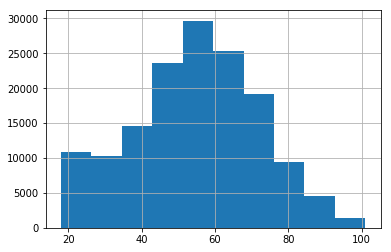

In [38]:
df_full.age.hist();

In [39]:
df_full.shape

(148805, 18)

Clean up offer_id column to make it cleaner

In [40]:
# Store unique values to a dictionary
offer_dict = pd.Series(df_full['offer_id'].unique()).to_dict()
# Then assign these values as integer values
offer_dict = dict([(value, key) for key, value in offer_dict.items()])
# Then map onto original values, overwritting previous id's
df_full['offer_id'] = df_full['offer_id'].map(offer_dict)

Let's check what a profile would look like with the transaction history and offer details

In [41]:
df_full[df_full["customer_id"]=="78afa995795e4d85b5d9ceeca43f5fef"]

,customer_id,time,offer_id,offer completed,offer received,offer viewed,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,1,0,75,2017-05-09,F,100000.0,5,7,bogo,5,1,1,0,1
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,0,1,75,2017-05-09,F,100000.0,5,7,bogo,5,1,1,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,132,0,1,0,0,75,2017-05-09,F,100000.0,5,7,bogo,5,1,1,0,1
16202,78afa995795e4d85b5d9ceeca43f5fef,168,1,0,1,0,75,2017-05-09,F,100000.0,0,3,informational,0,1,1,1,0
16203,78afa995795e4d85b5d9ceeca43f5fef,216,1,0,0,1,75,2017-05-09,F,100000.0,0,3,informational,0,1,1,1,0
30507,78afa995795e4d85b5d9ceeca43f5fef,408,2,0,1,0,75,2017-05-09,F,100000.0,10,7,bogo,10,1,1,1,0
30508,78afa995795e4d85b5d9ceeca43f5fef,408,2,0,0,1,75,2017-05-09,F,100000.0,10,7,bogo,10,1,1,1,0
30509,78afa995795e4d85b5d9ceeca43f5fef,510,2,1,0,0,75,2017-05-09,F,100000.0,10,7,bogo,10,1,1,1,0
48569,78afa995795e4d85b5d9ceeca43f5fef,504,3,0,1,0,75,2017-05-09,F,100000.0,5,5,bogo,5,1,1,1,1
48570,78afa995795e4d85b5d9ceeca43f5fef,510,3,1,0,0,75,2017-05-09,F,100000.0,5,5,bogo,5,1,1,1,1


- Seems like each person never recieved two offer of the same offer ids.
- Not everyone recieved all offers. May add bias in results as there may be external biases (i.e. someone may have prefered offer 7 but did not recieve it)

In [42]:
# Creating completed df
df_full_completed = df_full.loc[(df_full['offer completed'] == 1)]

## Data Analysis

#### What is the income distribution per gender

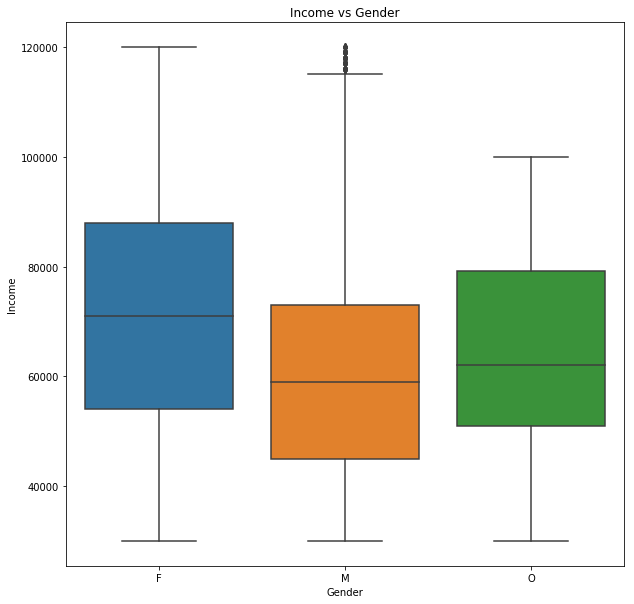

In [43]:
# General distribution (of all users)
plt.figure(figsize=[10,10])
sns.boxplot(
    data = profile,
    x = profile['gender'],
    y = profile['income']
)

plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')

plt.show();

#### Does the distributions looks different when the offer is completed (i.e. does it become more skewed by richer people buying more)

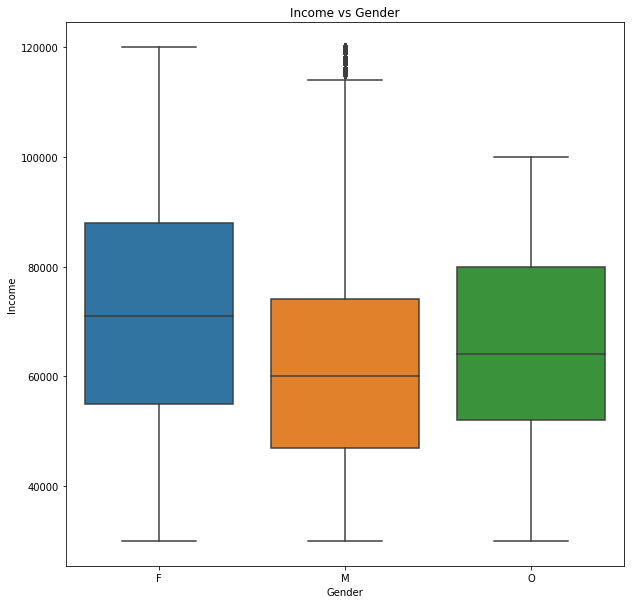

In [88]:
# When offer is completed
plt.figure(figsize=[10,10])
sns.boxplot(
    data = df_full[df_full['offer completed']==1],
    x = df_full['gender'],
    y = df_full['income']
)

plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')

plt.show();

- No difference between completed and overall profile data.
- The average female appears to have a higher income than average male. Slightly surprising since males were the most customers. (This was also checked for when the offer for not completed - the same distribution occured)

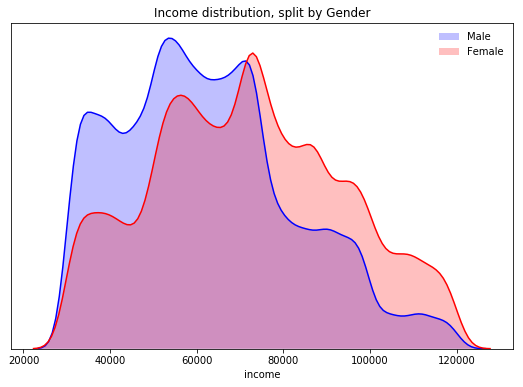

In [102]:
plt.figure(figsize=[9,6])
sns.distplot(df_full[df_full['gender']=='M']['income'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(df_full[df_full['gender']=='F']['income'],hist=False,color="r", kde_kws={"shade": True});
#sns.distplot(df_full[df_full['gender']=='O']['income'],hist=False,color="g", kde_kws={"shade": True});

plt.title('Income distribution, split by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female', 'Other'],frameon=False);

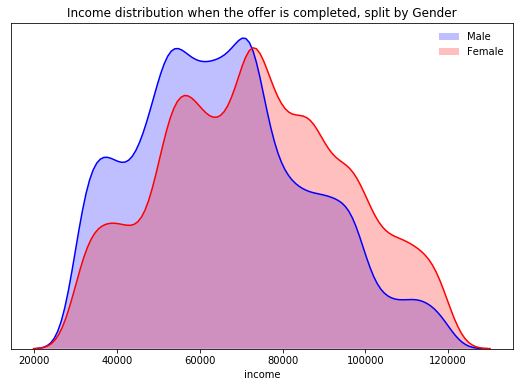

In [101]:
plt.figure(figsize=[9,6])
sns.distplot(df_full_completed[df_full_completed['gender']=='M']['income'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(df_full_completed[df_full_completed['gender']=='F']['income'],hist=False,color="r", kde_kws={"shade": True});
#sns.distplot(df_full_completed[df_full_completed['gender']=='O']['income'],hist=False,color="g", kde_kws={"shade": True});

plt.title('Income distribution when the offer is completed, split by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female', 'Other'],frameon=False);

#### Breakdown of which offers were the sent the most to customers

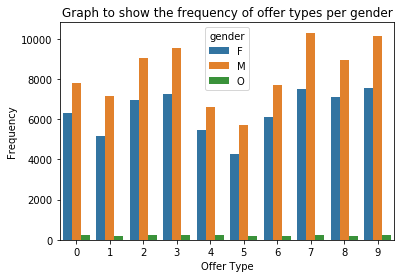

In [46]:
sns.countplot(
    data=df_full,
    hue="gender",
    x="offer_id");

plt.xlabel('Offer Type')
plt.ylabel('Frequency')
plt.title('Graph to show the frequency of offer types per gender');

- Males sent more offers in general.
- Makes sense as males are 40% more than females

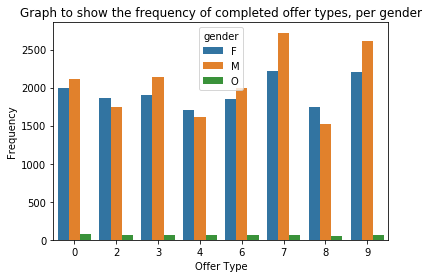

In [47]:
# When offer is completed
sns.countplot(
    data=df_full[df_full['offer completed']==1],
    hue="gender",
    x="offer_id");

plt.xlabel('Offer Type')
plt.ylabel('Frequency')
plt.title('Graph to show the frequency of completed offer types, per gender');

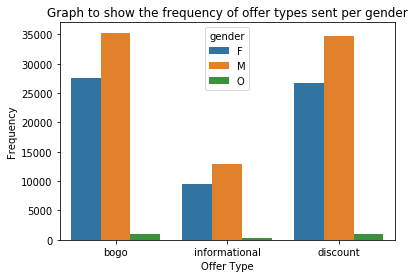

In [48]:
# Overall distribution
sns.countplot(
    data=df_full,
    hue="gender",
    x="offer_type");

plt.xlabel('Offer Type')
plt.ylabel('Frequency')
plt.title('Graph to show the frequency of offer types sent per gender');

Both bogo and discounts occurred the most

In [49]:
df_full.head()

,customer_id,time,offer_id,offer completed,offer received,offer viewed,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,1,0,75,2017-05-09,F,100000.0,5,7,bogo,5,1,1,0,1
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,0,1,75,2017-05-09,F,100000.0,5,7,bogo,5,1,1,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,132,0,1,0,0,75,2017-05-09,F,100000.0,5,7,bogo,5,1,1,0,1
3,e2127556f4f64592b11af22de27a7932,408,0,0,1,0,68,2018-04-26,M,70000.0,5,7,bogo,5,1,1,0,1
4,e2127556f4f64592b11af22de27a7932,420,0,0,0,1,68,2018-04-26,M,70000.0,5,7,bogo,5,1,1,0,1


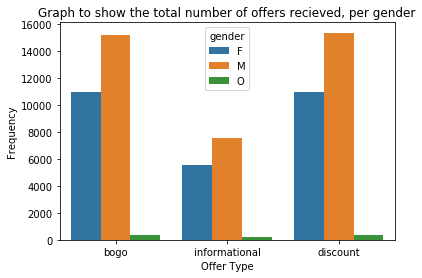

In [50]:
# Recieved offers
sns.countplot(
    data=df_full[df_full['offer received']==1],
    hue="gender",
    x="offer_type");

plt.xlabel('Offer Type')
plt.ylabel('Frequency')
plt.title('Graph to show the total number of offers recieved, per gender');

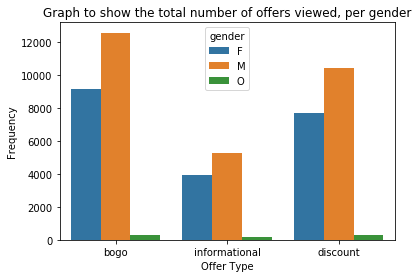

In [51]:
# Viewed offers
sns.countplot(
    data=df_full[df_full['offer viewed']==1],
    hue="gender",
    x="offer_type");

plt.xlabel('Offer Type')
plt.ylabel('Frequency')
plt.title('Graph to show the total number of offers viewed, per gender');

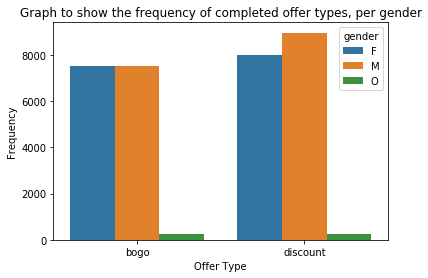

In [52]:
# Completed offers
sns.countplot(
    data=df_full[df_full['offer completed']==1],
    hue="gender",
    x="offer_type");

plt.xlabel('Offer Type')
plt.ylabel('Frequency')
plt.title('Graph to show the frequency of completed offer types, per gender');

- Discounts had a slightly higher completion rate vs bogos.
- Males had a big drop off

#### Customer response to different social media types

In [53]:
# Create an incercept for linear regression but also calculations below
df_full['intercept'] = 1

In [54]:
# Breakdown of which platform was used to send to users as a %
df_full.groupby('gender')['email', 'mobile', 'social', 'web'].sum()\
    .reset_index()\
    .set_index('gender')/df_full.intercept\
    .sum()*100

,email,mobile,social,web
gender,,,,
F,42.820470,39.133766,27.923121,34.652061
M,55.707806,51.255670,37.004805,44.836531
O,1.471725,1.326568,0.903195,1.186116


In [55]:
# Same as above but when the offer was completed
df_full.loc[(df_full['offer completed'] == 1)].groupby('gender')\
    ['email', 'mobile', 'social', 'web']\
    .sum()\
    .reset_index()\
    .set_index('gender')\
    /(df_full.loc[(df_full['offer completed'] == 1)]\
    .intercept.sum())*100

,email,mobile,social,web
gender,,,,
F,47.703736,42.454691,30.588090,41.980027
M,50.752065,45.758846,33.075453,45.385896
O,1.544199,1.350018,0.936999,1.362347


In [56]:
# Absolute Percentage Difference (percentage point difference)
-df_full.groupby('gender')['email', 'mobile', 'social', 'web'].sum().reset_index().set_index('gender')*100/df_full.intercept.sum()\
+ df_full.loc[(df_full['offer completed'] == 1)].groupby('gender')['email', 'mobile', 'social', 'web'].sum().reset_index().set_index('gender')*100 / (df_full.loc[(df_full['offer completed'] == 1)].intercept.sum())

,email,mobile,social,web
gender,,,,
F,4.883266,3.320925,2.664969,7.327966
M,-4.955740,-5.496824,-3.929352,0.549365
O,0.072474,0.023450,0.033804,0.176231


When possitive, the difference shows how effective the method of communication is:
- For email, men overall (55%) decreased (to 51%) implying men are less effected by the marketing. This was true for all platforms besides web.
-  Females seem to be more likely to make a purchase.
- Other genders were similar to females.

#### What was the breakdown of marketing?

By duration of offer:

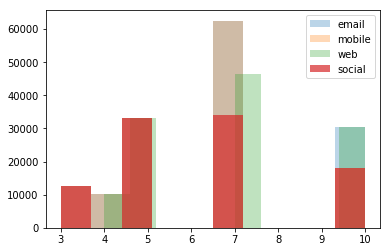

In [57]:
plt.hist(df_full.query("email == 1")['duration'], alpha = 0.3, label = 'email');
plt.hist(df_full.query("mobile == 1")['duration'], alpha = 0.3, label = 'mobile');
plt.hist(df_full.query("web == 1")['duration'], alpha = 0.3, label = 'web');
plt.hist(df_full.query("social == 1")['duration'], alpha = 0.7, label = 'social');

plt.legend();

In [58]:
email = df_full.query("email == 1")['duration'].value_counts().reset_index()
email['type'] = "email"
mobile = df_full.query("mobile == 1")['duration'].value_counts().reset_index()
mobile["type"] = "mobile"
web = df_full.query("web == 1")['duration'].value_counts().reset_index()
web["type"] = "web"
social = df_full.query("social == 1")['duration'].value_counts().reset_index()
social["type"] = "social"

In [59]:
market = pd.concat([email, mobile, web, social], axis=0)
market.rename(columns = {'index':'days'}, inplace = True)
market.sort_values("days")

,days,duration,type
3,3,12516,mobile
3,3,12516,email
3,3,12516,social
4,4,10144,email
4,4,10144,mobile
3,4,10144,web
1,5,33221,email
1,5,33221,mobile
1,5,33221,web
1,5,33221,social


Breakdown with income distribution:

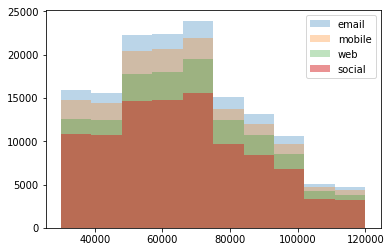

In [60]:
plt.hist(df_full.query("email == 1")['income'], alpha = 0.3, label = 'email');
plt.hist(df_full.query("mobile == 1")['income'], alpha = 0.3, label = 'mobile');
plt.hist(df_full.query("web == 1")['income'], alpha = 0.3, label = 'web');
plt.hist(df_full.query("social == 1")['income'], alpha = 0.5, label = 'social');

plt.legend();

Most marketing was sent using email across all age groups

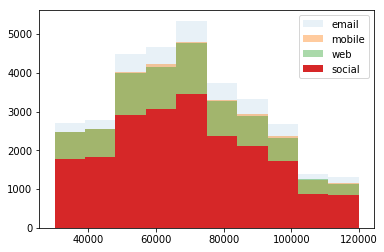

In [61]:
plt.hist(df_full_completed.query("email == 1")['income'], alpha = 0.1, label = 'email');
plt.hist(df_full_completed.query("mobile == 1")['income'], alpha = 0.4, label = 'mobile');
plt.hist(df_full_completed.query("web == 1")['income'], alpha = 0.4, label = 'web');
plt.hist(df_full_completed.query("social == 1")['income'], alpha = 1, label = 'social');

plt.legend();

In [62]:
df_full.groupby('offer completed')['email', 'mobile', 'web', 'social'].sum().reset_index().set_index("offer completed")

,email,mobile,web,social
offer completed,,,,
0,116361.0,107420.0,91261.0,77001.0
1,32444.0,29058.0,28787.0,20959.0


Mobile and web performed very similar when their offers were completed. Social media and email underperformed however these may have been harder to track.

In [63]:
df_full_completed.groupby('offer_id')['email', 'mobile', 'web', 'social'].sum().reset_index().set_index("offer_id")

,email,mobile,web,social
offer_id,,,,
0,4188.0,4188.0,4188.0,0.0
2,3657.0,3657.0,0.0,3657.0
3,4103.0,4103.0,4103.0,4103.0
4,3386.0,0.0,3386.0,0.0
6,3911.0,3911.0,3911.0,0.0
7,5003.0,5003.0,5003.0,5003.0
8,3310.0,3310.0,3310.0,3310.0
9,4886.0,4886.0,4886.0,4886.0


## Linear Regression

In [64]:
import statsmodels.api as sms;

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Is there any significance of viewing the offer and completing the offer?

- Very low r-squared values imply it isnt that important of a factor in completing the offer

Note for self: Both columns can not be a 1 as they are not sequential. Not a useful metric.

#### Is there any significance of higher incomes and completing offers?

In [65]:
lr = sms.OLS(df_full['offer completed'], df_full[['intercept', 'income']])
results_inc = lr.fit()
results_inc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        offer completed   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     821.6
Date:                Thu, 23 Nov 2023   Prob (F-statistic):          3.44e-180
Time:                        16:10:57   Log-Likelihood:                -79113.
No. Observations:              148805   AIC:                         1.582e+05
Df Residuals:                  148803   BIC:                         1.582e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1235      0.003     35.629      0.000       0.117       0.130
income      1.423e-06   4.97e-08     28.663      0.000    1.33e-06    1.52e-06
==============================================================================
Omnibus:                    27211.032   Durbin-Watson:                   2.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45612.818
Skew:                           1.355   Prob(JB):                         0.00
Kurtosis:                       2.867   Cond. No.                     2.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Very very low r-squared. Variables are likely independent of each other.

#### Is there any significance of the duration of the offer and completing it?

In [66]:
lr = sms.OLS(df_full['offer completed'], df_full[['intercept', 'duration']])
results_inc = lr.fit()
results_inc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        offer completed   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     4519.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:10:58   Log-Likelihood:                -77297.
No. Observations:              148805   AIC:                         1.546e+05
Df Residuals:                  148803   BIC:                         1.546e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0022      0.003     -0.626      0.531      -0.009       0.005
duration       0.0332      0.000     67.225      0.000       0.032       0.034
==============================================================================
Omnibus:                    25585.843   Durbin-Watson:                   2.600
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41516.712
Skew:                           1.291   Prob(JB):                         0.00
Kurtosis:                       2.837   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Weak correlation

## K-Nearest Neighbours Fit

Create a KNN model to understand how to maximise offers completed

#### Create new features for model

Map genders and offer type into integers for regression model

In [67]:
df_ml = df_full.drop(['became_member_on', 'customer_id'], axis=1)

In [68]:
# Make sure no na values
df_ml.isna().sum()

time               0
offer_id           0
offer completed    0
offer received     0
offer viewed       0
age                0
gender             0
income             0
difficulty         0
duration           0
offer_type         0
reward             0
email              0
mobile             0
social             0
web                0
intercept          0
dtype: int64

In [69]:
# Map Genders
genders = {'O': 2, 'M': 1, 'F': 0}
df_ml['gender'] = df_ml['gender'].map(genders)

In [70]:
# Map Offers
offers = {'bogo': 0, 'discount': 1, 'informational': 2}
df_ml['offer_type'] = df_ml['offer_type'].map(offers)

Predict if an offer is completed using both email and mobile

In [71]:
X = df_ml.drop(['offer completed'], axis=1)
Y = df_ml['offer completed']

In [72]:
df_ml.head()

,time,offer_id,offer completed,offer received,offer viewed,age,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web,intercept
0,0,0,0,1,0,75,0,100000.0,5,7,0,5,1,1,0,1,1
1,6,0,0,0,1,75,0,100000.0,5,7,0,5,1,1,0,1,1
2,132,0,1,0,0,75,0,100000.0,5,7,0,5,1,1,0,1,1
3,408,0,0,1,0,68,1,70000.0,5,7,0,5,1,1,0,1,1
4,420,0,0,0,1,68,1,70000.0,5,7,0,5,1,1,0,1,1


In [73]:
X.shape, Y.shape

((148805, 16), (148805,))

In [74]:
Y.head()

0    0
1    0
2    1
3    0
4    0
Name: offer completed, dtype: uint8

Create test and train dataset

In [75]:
import re
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

In [76]:
# Split into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [77]:
# Create KNN with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

In [78]:
# Fit classifiers to training data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [79]:
# Print score/ accuracy
print(" {} nn score: {} ".format(5,knn.score(X_test,y_test)))

 5 nn score: 0.7927825005880179 


### k-Fold Cross-Validation
Cross-validation is when the dataset is randomly split up into ‘k’ groups. One of the groups is used as the test set and the rest are used as the training set. The model is trained on the training set and scored on the test set. Then the process is repeated until each unique group as been used as the test set.

For example, for 5-fold cross validation, the dataset would be split into 5 groups, and the model would be trained and tested 5 separate times so each group would get a chance to be the test set.

The train-test-split method we used in earlier is called ‘holdout’. Cross-validation is better than using the holdout method because the holdout method score is dependent on how the data is split into train and test sets. Cross-validation gives the model an opportunity to test on multiple splits so we can get a better idea on how the model will perform on unseen data.

In order to train and test our model using cross-validation, we will use the ‘cross_val_score’ function with a cross-validation value of 5. ‘cross_val_score’ takes in our k-NN model and our data as parameters. Then it splits our data into 5 groups and fits and scores our data 5 seperate times, recording the accuracy score in an array each time. We will save the accuracy scores in the ‘cv_scores’ variable.

To find the average of the 5 scores, we will use numpy’s mean function, passing in ‘cv_score’.

In [80]:
from sklearn.model_selection import cross_val_score
import numpy as np

#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=5)
#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X, Y, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print("cv_scores mean:{}".format(np.mean(cv_scores)))

[ 0.79524226  0.77594839  0.80951581  0.78502066  0.78729839]
cv_scores mean:0.790605101012277


Using cross-validation, our mean score is about 79%. This is a more accurate representation of how our model will perform on unseen data than using the holdout method.

In [81]:
# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = knn.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

0.3804202931966486

In [82]:
test_preds = knn.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

0.4552114886643154

Low RMSE - good!

#### Confusion Matrix

In [83]:
y_pred = knn.predict(X_test)
y_true=y_test

#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

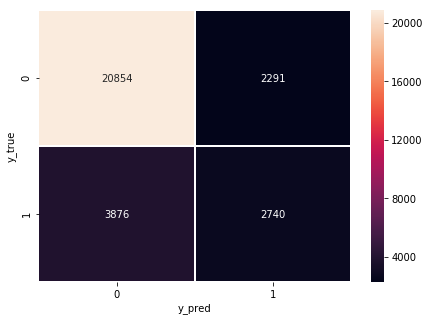

In [84]:
import seaborn as sns 
f, ax = plt.subplots(figsize = (7,5))

sns.heatmap(cm, annot = True, linewidths= 0.5, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [85]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.84      0.90      0.87     23145
          1       0.54      0.41      0.47      6616

avg / total       0.78      0.79      0.78     29761



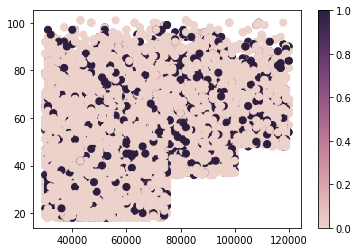

In [86]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test["income"], X_test["age"], c=test_preds, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

With this model we can predict new observations to see whether or not a user is likely to complete a offer!

But, perhaps, a logistic regression curve would have been more suitable instead of a KNN as time, income and age were the only continous variables that were suitable to plot.

## Summary

Despite emails having the largest proportion of offers completed, the correlation between offer viewed and offer completed was quite low. Other factors should be considered such as promotion within the store and regular customer habbits.

An KNN model was created which had a model accuracy of 80%. This would be ideal for predicting new observations and see which customers are likely to complete a offer.

See full analysis on [medium](https://medium.com/@ali5s.atif/starbucks-send-an-offer-that-no-one-can-resist-d1ee29d25c3e)